# Lab 2: Grayscale Colorizer

# Exercise 1

## 1. Dataset and preprocessing
We import the CIFAR-10 dataset (60,000 colour images of size 32×32×3 in 10 classes) using the torchvision library.  
Pixels are then normalised to the [0,1] range using `ToTensor()`.   
We merge the original train and test splits provided from the library and randomly divide them into:
- 80% training
- 10% validation
- 10% test

This split is done with `random_split` from PyTorch.

In [ ]:
import torch, torchvision
from torch.utils.data import random_split, DataLoader, ConcatDataset
from torchvision import datasets, transforms

# normalize to [0,1]
transform = transforms.Compose([
    transforms.ToTensor(),                
])

# Load CIFAR10 train and test sets and concatenate them
all_data = ConcatDataset([
    datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform),
    datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
])

n = len(all_data)

# Get sizes for train test and val
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = int(0.1 * n)

# Split dataset
train_set, val_set, test_set = random_split(all_data, [n_train, n_val, n_test])

# DataLoaders
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)


Files already downloaded and verified
Files already downloaded and verified


(375, 47, 47)


## 2. Convolutional autoencoder architecture

The main autoencoder compresses 32×32 RGB images into a low-dimensional latent representation and then reconstructs them.

### Main model:

**Encoder:**
- Conv2d: 3 → 8 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (32×32 -> 16×16)
- Conv2d: 8 → 12 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (16×16 -> 8×8)
- Conv2d: 12 → 16 channels, 3×3 kernel, padding=1, ReLU  

We can calculate the latent space using the following parameters and formula:

- W - Input volume = 8
- K - Kernel (filter) size = 3
- P - Padding = 1
- S - Stride = 1
- C - Number of channels = 16

Latent space is ((W-K+2P)/S+1)^2 * C = ((8-3+2*1)/1+1)^2 * 16 = 1024

**Decoder:**
- Upsample: factor 2 (8×8 -> 16×16)
- Conv2d: 16 → 12 channels, 3×3, ReLU
- Upsample: factor 2 (16×16 -> 32×32)
- Conv2d: 12 → 3 channels, 3×3, ReLU

We train the model to minimise the mean squared error between the input and output images.

**Layer Functionality**
- Conv2d applies a set of learnable filters that slide over the image that extracts features (edges, texture, shape, etc.) from the image
- ReLU introduces non-linearity and allows the model to learn non-linear features
- MaxPool2d reduces spacial dimensionality (halves the size of the height and width) and compressed data to help encoder create a compact latent representation
- Upsample increases spacial dimensionality to reverse downsampling and rebuild the image resolution

Three slightly different models are also created:

### Shallow model:

**Encoder:**
- Conv2d: 3 → 8 channels, 3×3 kernel, padding=1, ReLU
- Conv2d: 8 → 16 channels, 3×3 kernel, padding=1, ReLU

**Decoder:**
- ConvTranspose2d: 16 → 8 channels, 3×3, ReLU
- ConvTranspose2d: 8 → 3 channels, 3×3, Sigmoid

### Deep model:

**Encoder:**
- Conv2d: 3 → 16 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (32×32 -> 16×16)
- Conv2d: 16 → 32 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (16x16 -> 8x8)
- Conv2d: 32 → 64 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (8x8 -> 4x4)

**Decoder:**
- Upsample: factor 2 (4x4 -> 8x8)
- Conv2d: 64 → 32 channels, 3×3, ReLU
- Upsample: factor 2 (8x8 -> 16x16)
- Conv2d: 32 → 16 channels, 3×3, ReLU
- Upsample: factor 2 (16x16 -> 32x32)
- Conv2d: 16 → 3 channels, 3×3, Sigmoid

### Bigger filter model:


**Encoder:**
- Conv2d: 3 → 8 channels, 5×5 kernel, padding=2, ReLU
- MaxPool2d: 2×2 (32×32 -> 16×16)
- Conv2d: 8 → 16 channels, 5×5 kernel, padding=2, ReLU
- MaxPool2d: 2×2 (16x16 -> 8×8)

**Decoder:**
- Upsample: factor 2 (8x8 -> 16×16)
- Conv2d: 16 → 8 channels, 5×5, ReLU
- Upsample: factor 2 (16x16 -> 32x32)
- Conv2d: 8 → 3 channels, 5×5, Sigmoid


In [2]:
import torch.nn as nn

# ------------------------ MAIN MODEL DEFINITION ------------------------ #
class ConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

    
        #Auto encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(in_channels = 8, out_channels = 12, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 16, out_channels = 12, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 12, out_channels = 3, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU()
            
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        # tuple (reconstruction, latent)
        return out, h

# ------------------------ SHALLOWER MODEL DEFINITION ------------------------ #
class ShallowConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

# ------------------------ DEEPER MODEL DEFINITION ------------------------ #
class DeepConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h


# ------------------------ BIGGER FILTER MODEL DEFINITION ------------------------ #

class BiggerFilterConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 8, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 3, 5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h



## 3. Training procedure

We train the model with:
- Optimizer: Adam
- Learning rate: 1e-3
- Batch size: 128
- Number of epochs: 50

At each epoch we compute:
- Training loss on the training set
- Validation loss on the validation set

In [ ]:
import torch
import torch.optim as optim

# GPU acceleration for faster training if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device being used: {device}")

def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.01, device=device):

    model.to(device)
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    validation_losses = []

    for e in range(epochs):
        model.train()
        current_loss = 0.0
        for batch_idx, (img, _) in enumerate(train_loader):
            
            img = img.to(device)
            # tuple returned from foward(x)
            reconstruction, latent = model(img)
            optimizer.zero_grad()

            # when the input equal to the target 
            loss = criterion(reconstruction, img)

            loss.backward()
            optimizer.step()

            current_loss += loss.item() * img.size(0)

        epoch_train_loss = current_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)


        model.eval()
        current_loss_val = 0.0

        with torch.no_grad():
            for img, _ in val_loader:
                img = img.to(device)
                reconstruction, latent = model(img)
                loss = criterion(reconstruction, img)
                current_loss_val += loss.item() * img.size(0)

        epoch_val_loss = current_loss_val / len(val_loader.dataset)
        validation_losses.append(epoch_val_loss)

        
        print(f"Epoch {e+1}/{epochs} "
            f"- Train loss: {epoch_train_loss:.4f}, Validation loss: {epoch_val_loss:.4f}")
        
    return model, train_losses, validation_losses



Device being used: cpu


In [39]:
baseModel = ConvolutionAutoEncoder()
trainedModel, train_losses, validation_losses = train_model(baseModel, train_loader, val_loader, epochs=50, learning_rate=0.001, device=device)

# Saving the trained model
torch.save(trainedModel.state_dict(), 'Base_conv_autoencoder.pth')


Epoch 1/50 - Train loss: 0.0256, Validation loss: 0.0089
Epoch 2/50 - Train loss: 0.0078, Validation loss: 0.0071
Epoch 3/50 - Train loss: 0.0067, Validation loss: 0.0065
Epoch 4/50 - Train loss: 0.0062, Validation loss: 0.0060
Epoch 5/50 - Train loss: 0.0059, Validation loss: 0.0058
Epoch 6/50 - Train loss: 0.0057, Validation loss: 0.0057
Epoch 7/50 - Train loss: 0.0055, Validation loss: 0.0055
Epoch 8/50 - Train loss: 0.0053, Validation loss: 0.0053
Epoch 9/50 - Train loss: 0.0052, Validation loss: 0.0052
Epoch 10/50 - Train loss: 0.0051, Validation loss: 0.0052
Epoch 11/50 - Train loss: 0.0050, Validation loss: 0.0051
Epoch 12/50 - Train loss: 0.0049, Validation loss: 0.0049
Epoch 13/50 - Train loss: 0.0049, Validation loss: 0.0048
Epoch 14/50 - Train loss: 0.0048, Validation loss: 0.0050
Epoch 15/50 - Train loss: 0.0047, Validation loss: 0.0047
Epoch 16/50 - Train loss: 0.0047, Validation loss: 0.0047
Epoch 17/50 - Train loss: 0.0046, Validation loss: 0.0047
Epoch 18/50 - Train los

## 4. Results

### 4.1 Loss curves

Figure 1 shows the evolution of the training and validation MSE loss over epochs.  
The validation loss decreases and then stabilises after about 10 epochs, which indicates that the autoencoder has converged.

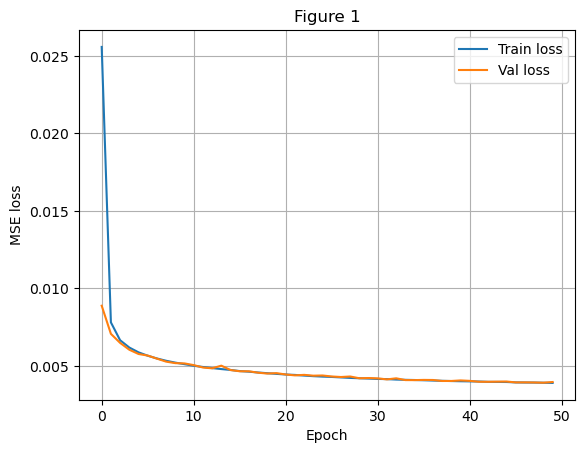

In [40]:
import matplotlib.pyplot as plt
def plot_losses(train_losses, validation_losses):
    plt.figure()
    plt.plot(train_losses, label="Train loss")
    plt.plot(validation_losses, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.legend()
    plt.grid(True)
    plt.title("Figure 1")
    plt.show()

plot_losses(train_losses, validation_losses)

### 4.2 Test performance

After training, we evaluate the model on the test set.  

In [41]:
def evaluate_model(model, data_loader, device=device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, images)
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

    return total_loss / total_samples

In [42]:
test_loss = evaluate_model(trainedModel, test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0039


### 4.3 Visual inspection

Figure 2 illustrates some original input images and their reconstructions.  
The reconstructions are slightly blurred but preserve the main objects and colours, which is expected for a simple convolutional autoencoder.


In [43]:
import torch
import matplotlib.pyplot as plt

def show_reconstruction(model, test_loader, device=device, num_images=5, title=""):
    model.eval()

    # 1. Take a single batch from the test (or val) loader
    img, _ = next(iter(test_loader)) 
    img = img.to(device)

    # 2. Get reconstructions
    with torch.no_grad():
        reconstruction, latent = model(img)         

    # 3. Move to CPU and (optionally) undo normalization
    orig = img.cpu()
    rec  = reconstruction.cpu()

    # 4. Plot first 7 originals and their reconstructions
    n_show = 7
    fig, ax = plt.subplots(2, n_show, figsize=(15, 4), dpi=250)

    for i in range(n_show):
        # [C, H, W] -> [H, W, C]
        img_np = orig[i].numpy().transpose((1, 2, 0))
        rec_np = rec[i].numpy().transpose((1, 2, 0))

        ax[0, i].imshow(img_np)
        ax[0, i].axis('off')

        ax[1, i].imshow(rec_np)
        ax[1, i].axis('off')
    ax[0, 0].set_title('Original')
    ax[1, 0].set_title('Reconstructed')
    plt.tight_layout()
    plt.show()

    # remember to add title to the graph 


# Excersize 2
Here, we train all four different (created above) models and we calculate the train, validation, and test loss.



Training model: Base
Epoch 1/10 - Train loss: 0.0240, Validation loss: 0.0107
Epoch 2/10 - Train loss: 0.0094, Validation loss: 0.0087
Epoch 3/10 - Train loss: 0.0082, Validation loss: 0.0079
Epoch 4/10 - Train loss: 0.0076, Validation loss: 0.0074
Epoch 5/10 - Train loss: 0.0072, Validation loss: 0.0070
Epoch 6/10 - Train loss: 0.0067, Validation loss: 0.0064
Epoch 7/10 - Train loss: 0.0061, Validation loss: 0.0060
Epoch 8/10 - Train loss: 0.0059, Validation loss: 0.0058
Epoch 9/10 - Train loss: 0.0057, Validation loss: 0.0057
Epoch 10/10 - Train loss: 0.0055, Validation loss: 0.0054

Training model: Simple
Epoch 1/10 - Train loss: 0.0242, Validation loss: 0.0097
Epoch 2/10 - Train loss: 0.0067, Validation loss: 0.0056
Epoch 3/10 - Train loss: 0.0052, Validation loss: 0.0050
Epoch 4/10 - Train loss: 0.0048, Validation loss: 0.0047
Epoch 5/10 - Train loss: 0.0046, Validation loss: 0.0045
Epoch 6/10 - Train loss: 0.0044, Validation loss: 0.0044
Epoch 7/10 - Train loss: 0.0043, Validati

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.058177076..1.0897877].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0645471].



 Model Performance Summary:
Base            | Test Loss: 0.005386
Simple          | Test Loss: 0.003884
Deep            | Test Loss: 0.007590
WideKernel      | Test Loss: 0.005225


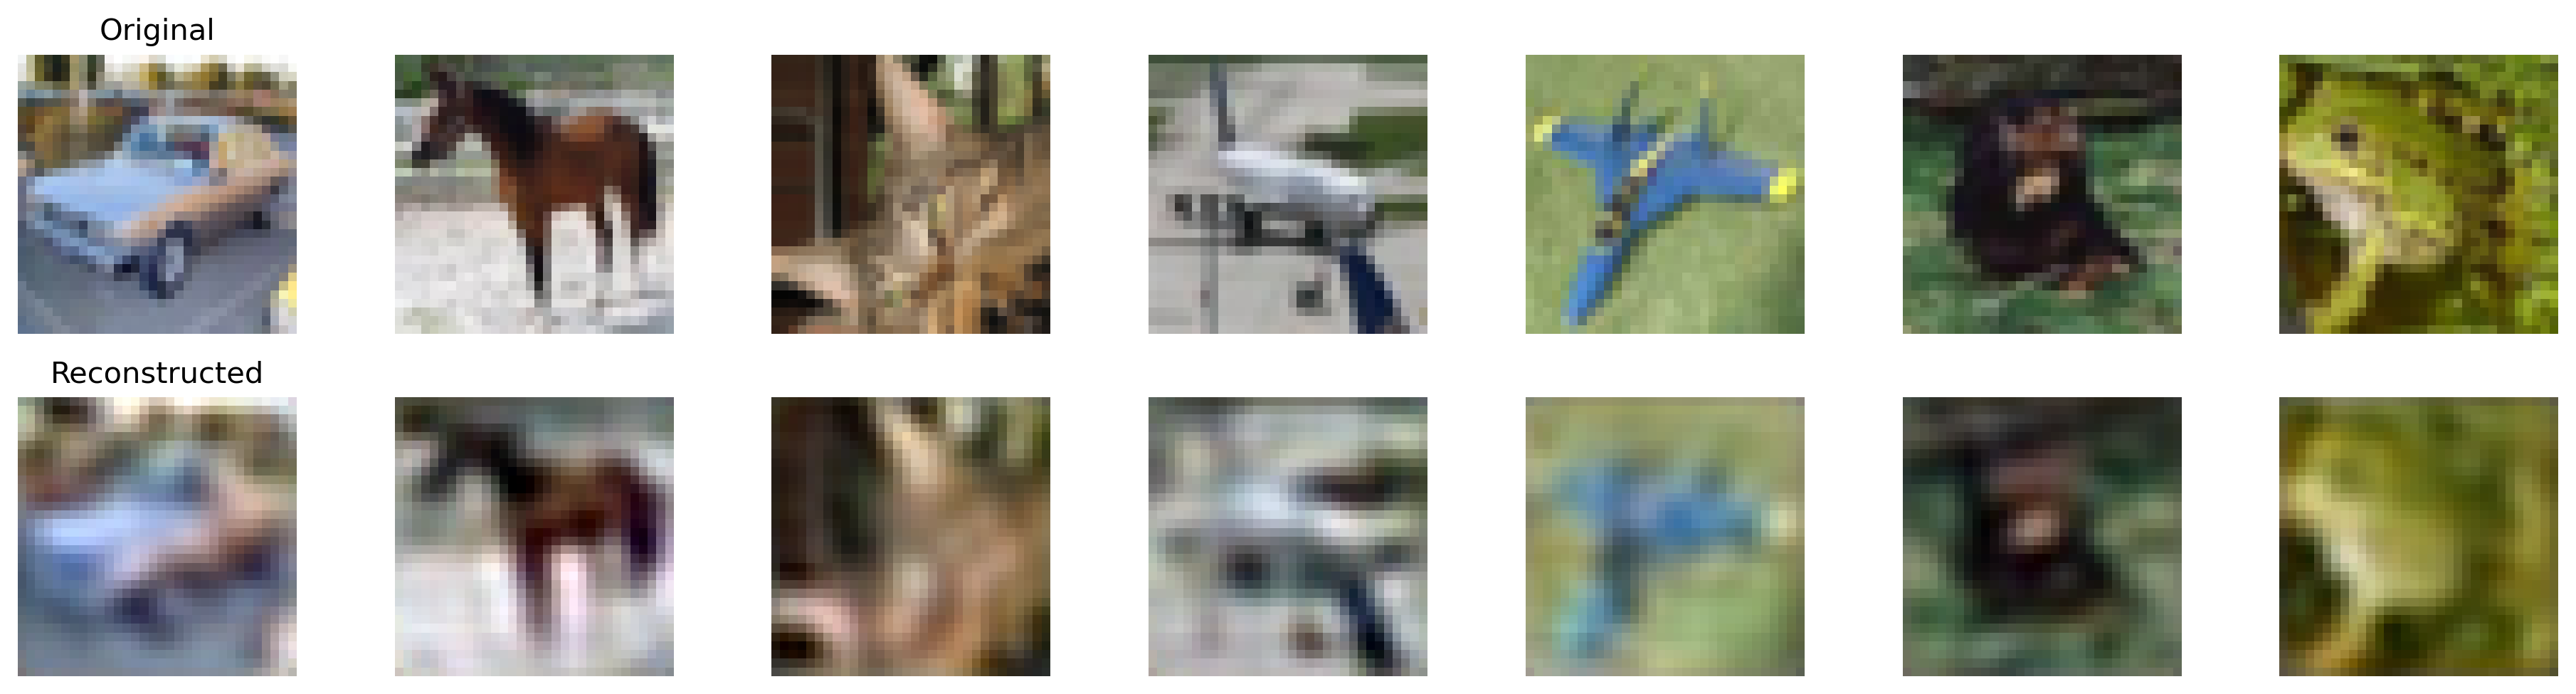

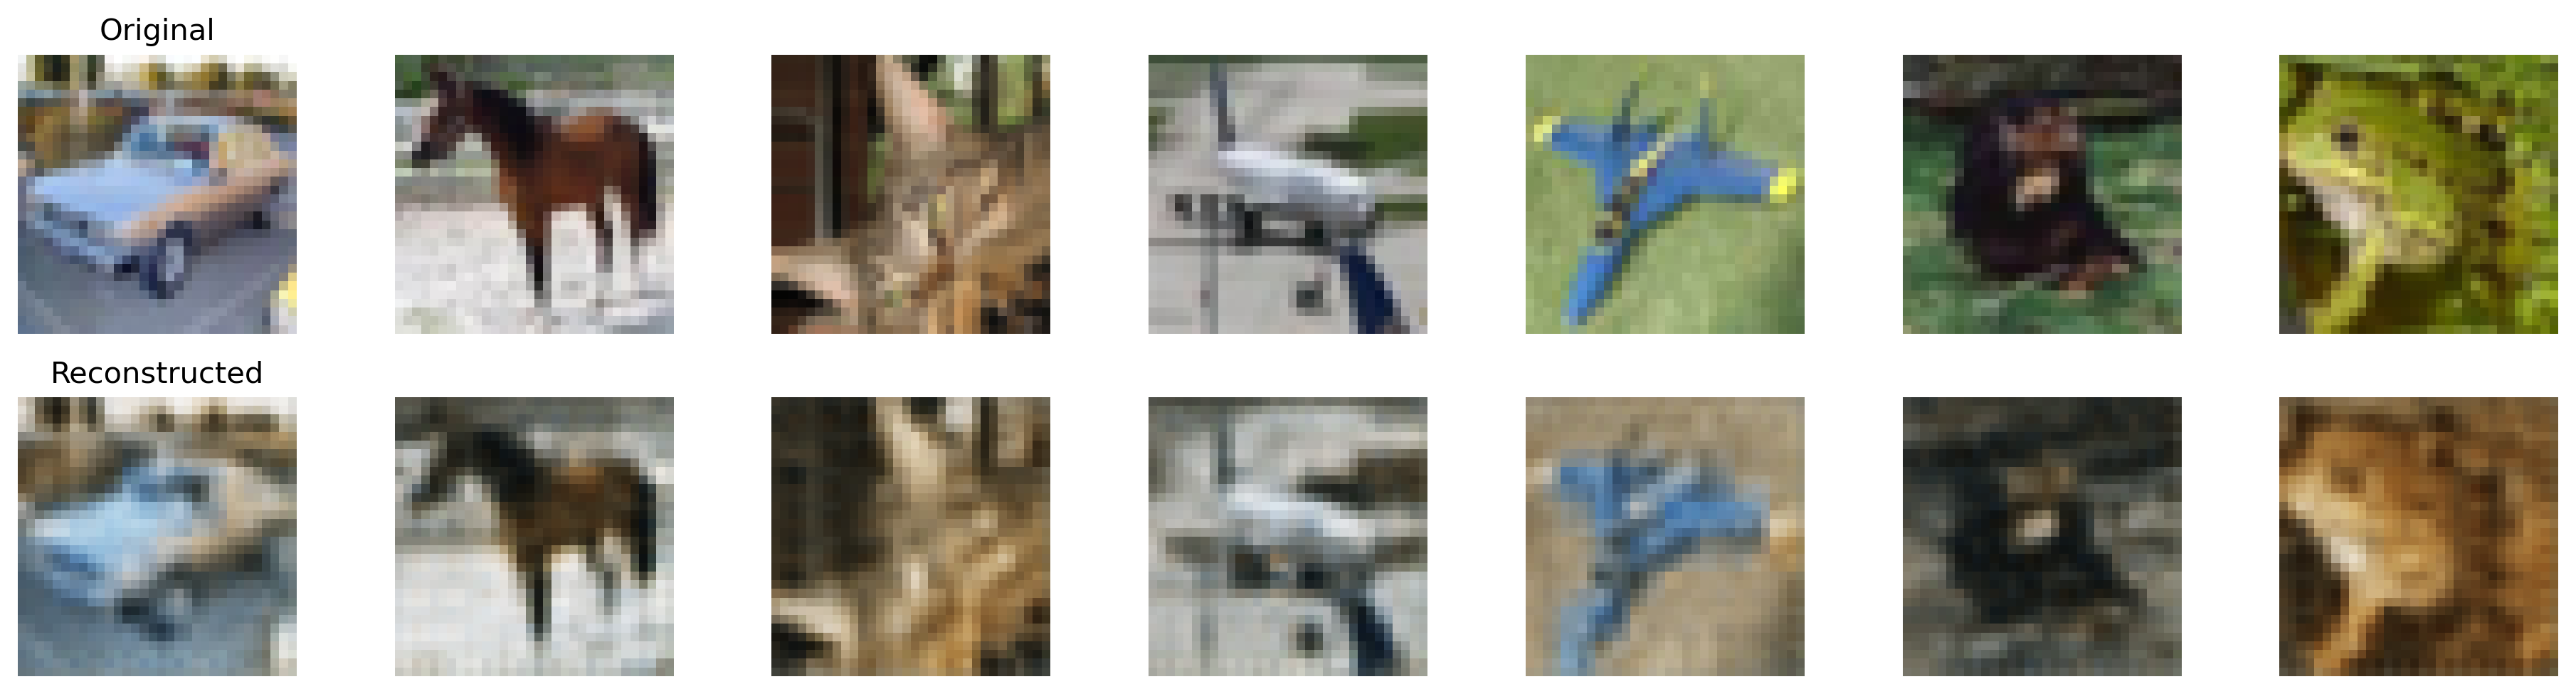

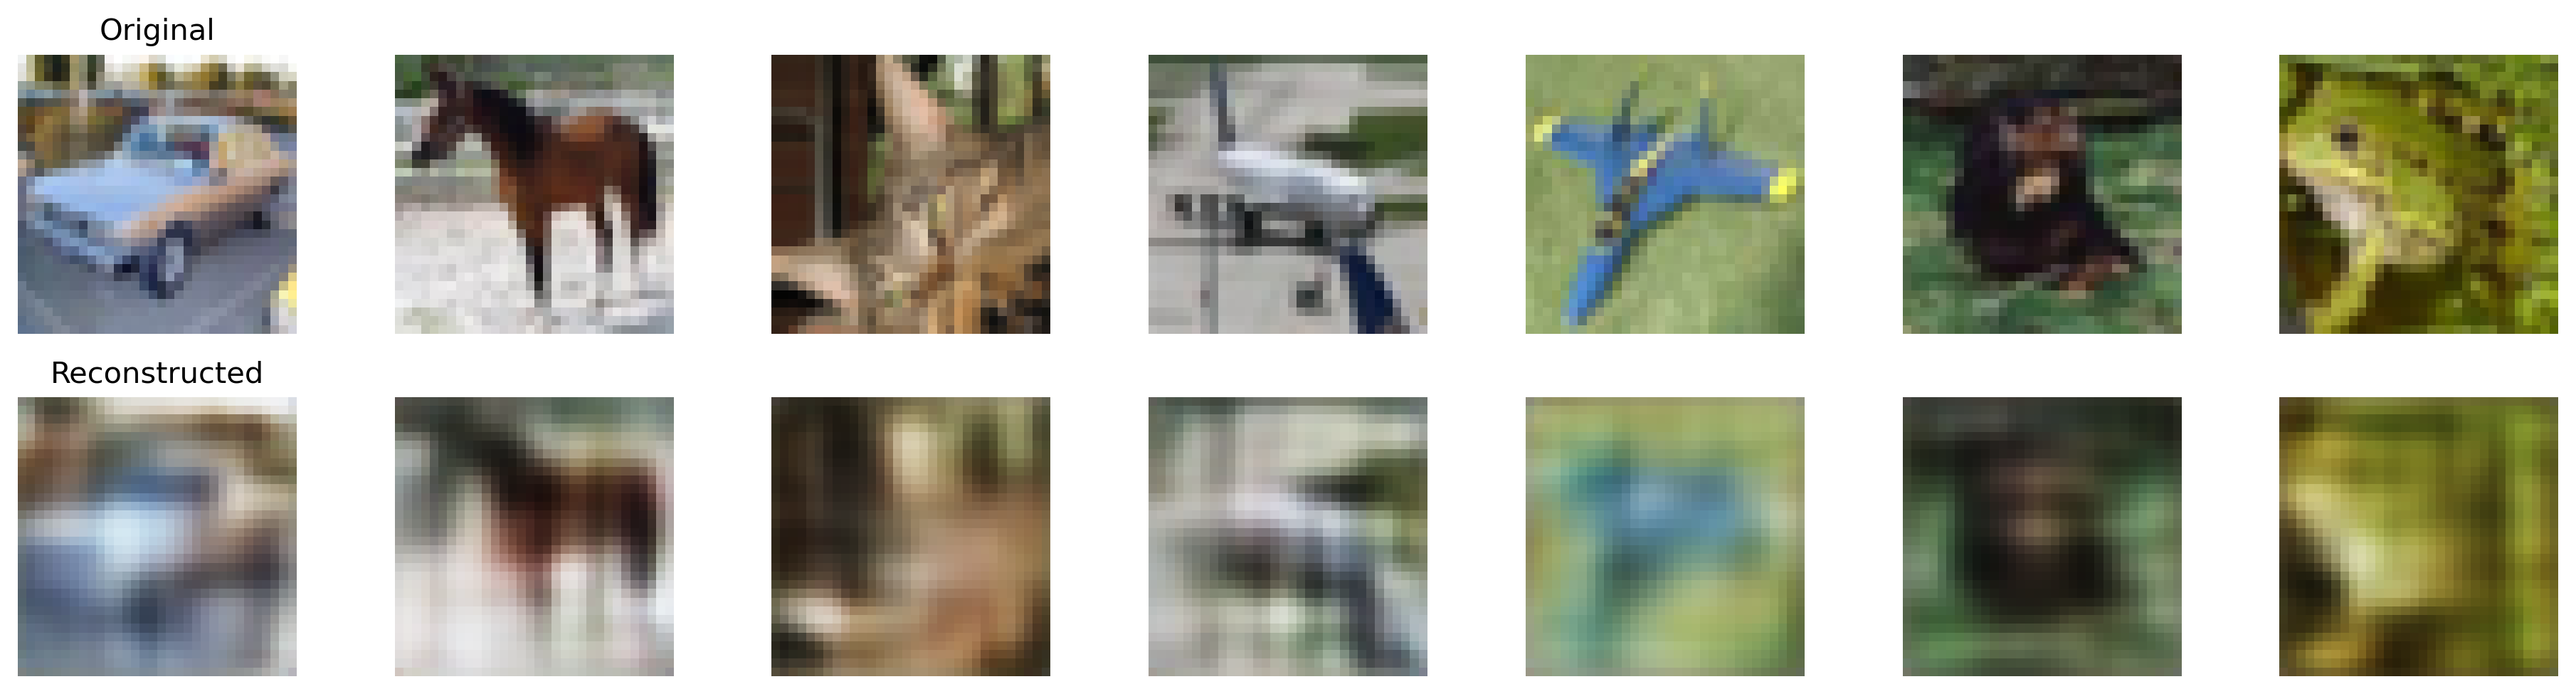

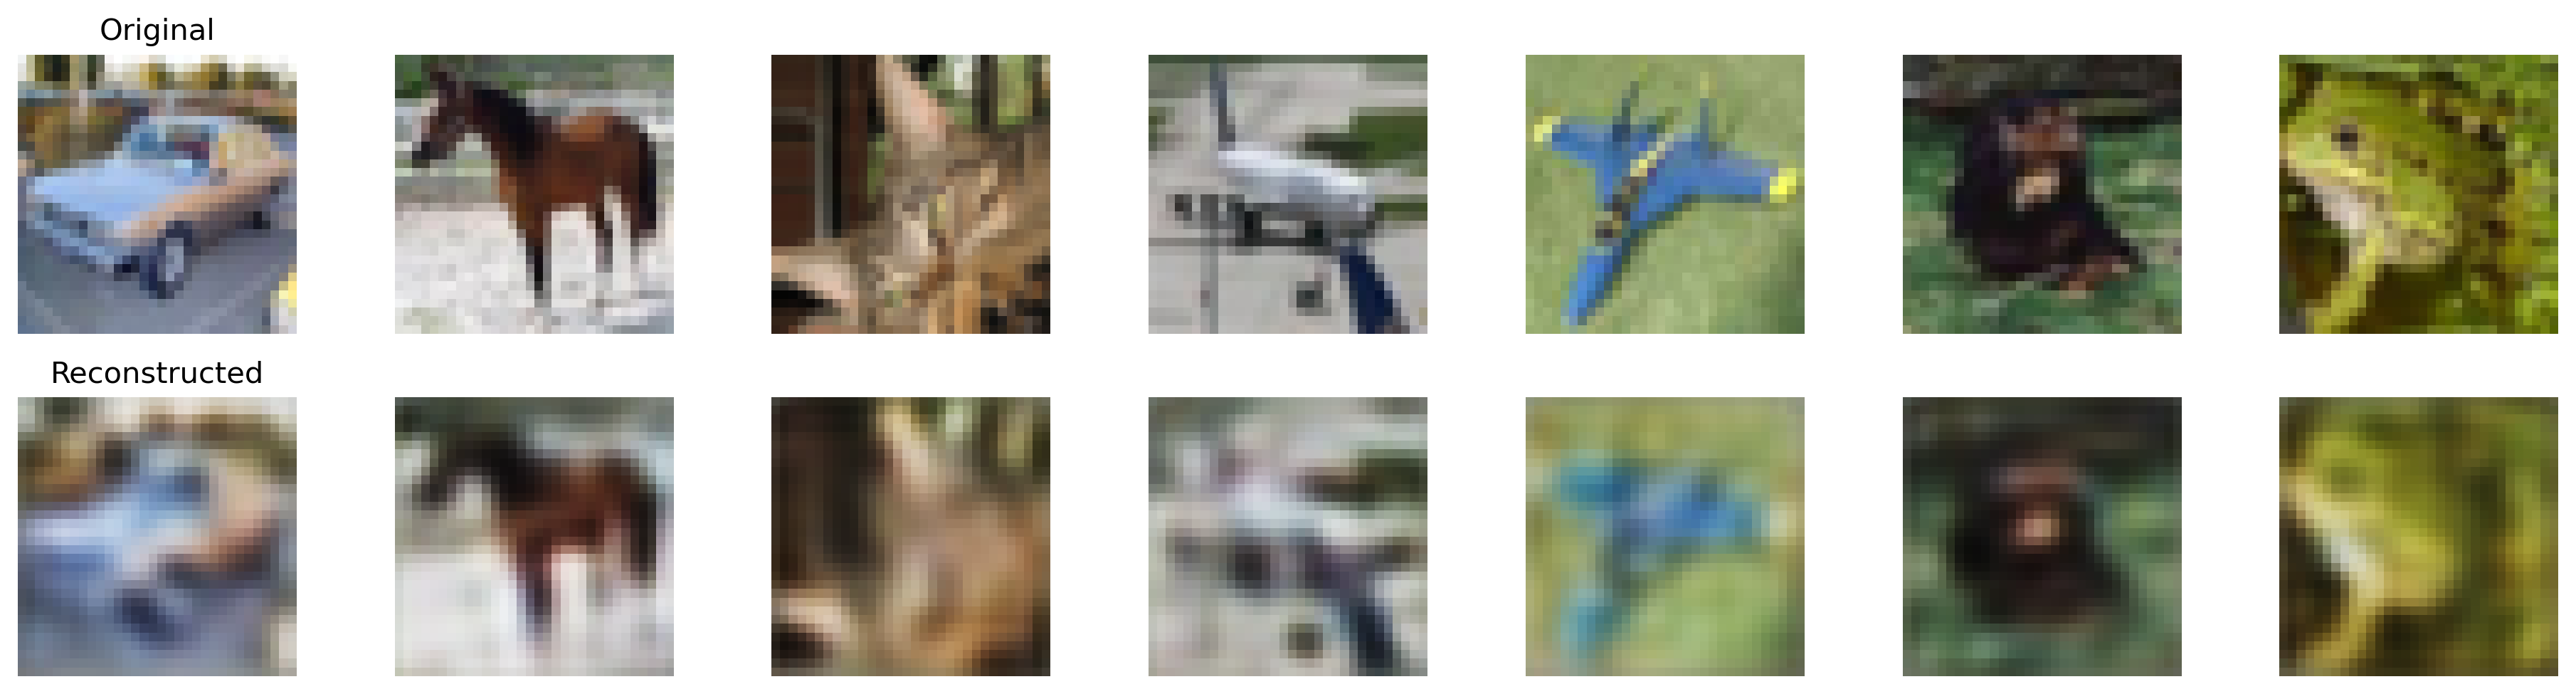

In [44]:
models_to_test = {
    "Base": ConvolutionAutoEncoder(),
    "Simple": ShallowConvolutionAutoEncoder(),
    "Deep": DeepConvolutionAutoEncoder(),
    "WideKernel": BiggerFilterConvolutionAutoEncoder()
}

trained_models = {}

results = {}

for name, model in models_to_test.items():
    print(f"\n======================")
    print(f"Training model: {name}")
    print(f"======================")

    trained_model, train_losses, validation_losses = train_model(model, train_loader, val_loader, epochs=10, learning_rate=1e-3)
    
    # Saving the trained model
    torch.save(trained_model.state_dict(), f'{name.lower()}_conv_autoencoder.pth')

    test_loss = evaluate_model(trained_model, test_loader)

    results[name] = {
        "model": trained_model,
        "val_loss": validation_losses,
        "test_loss": test_loss
    }



# Show summary of results
print("\n Model Performance Summary:")
for name, entry in results.items():
    print(f"{name:<15} | Test Loss: {entry['test_loss']:.6f}")

# Optionally, show all the reconstructions
for name, entry in results.items():
    model = entry["model"]
    show_reconstruction(model, test_loader, device=device, title=f"Reconstruction - {name}")


## Model Performance Analysis:

The model performance is as follows:

**Model Performance Summary:**
- Base            | Test Loss: 0.005386
- Simple          | Test Loss: 0.003884
- Deep            | Test Loss: 0.007590
- WideKernel      | Test Loss: 0.005225

Suprisingly, the simplest model has the lowest loss. 
This could be because this model has the largest latent space.

- W - Input volume = 32
- K - Kernel (filter) size = 3
- P - Padding = 1
- S - Stride = 1
- C - Number of channels = 16

Latent space: ((32-3+2*1)/2+1)^2 * 16 = 4356

This is more than 4 times greater than the latent space for the first model.
It is possible that since the image isn't compressed at all by the model, that the model has an easier time replicating it.
Even looking at the images above, the shallow model seems to reproduce the images the best, although having a slight change in color (which the other models don't have)


However, the deep model has the same latent space as the main model, with a significantly worse loss and image recreation performance.

- W - Input volume = 4
- K - Kernel (filter) size = 3
- P - Padding = 1
- S - Stride = 1
- C - Number of channels = 4

Latent space: ((4-3+2*1)/1+1)^2 * 64 = 1024

Thus, image quality is not the only determined by the latent space of a model.



# Exercise 3
## 3.1 Baseline colorization: grayscale -> RGB

In this baseline, we convert each CIFAR-10 image to grayscale (and replicate it
to 3 channels) and train the convolutional autoencoder from Exercise 2 to reconstruct
the original RGB image.

- **Input**: grayscale image replicated to 3 channels (shape [3, 32, 32])
- **Target**: original RGB image (shape [3, 32, 32])
- **Loss**: mean squared error (MSE)
- **Splits**: 80% train, 10% validation, 10% test (as before)


In [45]:
# --- Cell: dataset for baseline gray->RGB colorization ---
import torch
from torch.utils.data import Dataset, ConcatDataset, random_split, DataLoader
from torchvision import datasets, transforms

# Base CIFAR-10 without transforms (so we can build paired input/target)
base_train = datasets.CIFAR10(root="./data", train=True,  download=True, transform=None)
base_test  = datasets.CIFAR10(root="./data", train=False, download=True, transform=None)

class GrayToColorCIFAR(Dataset):
    """
    Returns:
      x: grayscale image replicated to 3 channels, shape [3, 32, 32], in [0,1]
      y: original RGB image, shape [3, 32, 32], in [0,1]
    """
    def __init__(self, baseds):
        self.baseds = baseds
        self.t_in  = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
        ])
        self.t_tgt = transforms.ToTensor()

    def __len__(self): 
        return len(self.baseds)

    def __getitem__(self, idx):
        img, _ = self.baseds[idx]     # PIL RGB
        x = self.t_in(img)            # [3,H,W] grayscale replicated to 3ch
        y = self.t_tgt(img)           # [3,H,W] RGB
        return x, y

# Merge original train+test and re-split 80/10/10
all_color = ConcatDataset([GrayToColorCIFAR(base_train), GrayToColorCIFAR(base_test)])
n = len(all_color)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val

train_set_c, val_set_c, test_set_c = random_split(all_color, [n_train, n_val, n_test])

batch_size = 128
train_loader_c = DataLoader(train_set_c, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader_c   = DataLoader(val_set_c,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_c  = DataLoader(test_set_c,  batch_size=batch_size, shuffle=False, num_workers=0)

print("Baseline gray->RGB dataset sizes:",
      len(train_set_c), len(val_set_c), len(test_set_c))


Files already downloaded and verified
Files already downloaded and verified
Baseline gray->RGB dataset sizes: 48000 6000 6000


We now train the Y->CbCr autoencoder with the same settings
(Adam, MSE, 15 epochs) and record training and validation losses.


In [46]:
# --- Cell: setup baseline colorizer training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model_c = ConvolutionAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer_c = optim.Adam(model_c.parameters(), lr=1e-3)
epochs_c = 50


Device: cpu


In [48]:
# --- Cell: train baseline gray->RGB colorizer ---
train_losses_c = []
val_losses_c = []

log_every = 100  # print every N batches

print()
print(f"{'Epoch':>5} | {'Train MSE':>10} | {'Val MSE':>10}")
print("-" * 32)

for e in range(1, epochs_c + 1):
    # ---- TRAIN ----
    model_c.train()
    running_train = 0.0
    processed = 0

    for batch_idx, (x_gray, y_rgb) in enumerate(train_loader_c, start=1):
        x_gray = x_gray.to(device)
        y_rgb  = y_rgb.to(device)

        optimizer_c.zero_grad()
        y_pred, _ = model_c(x_gray)
        loss = criterion(y_pred, y_rgb)
        loss.backward()
        optimizer_c.step()

        bs = x_gray.size(0)
        running_train += loss.item() * bs
        processed += bs


    epoch_train = running_train / len(train_loader_c.dataset)
    train_losses_c.append(epoch_train)

    # ---- VALIDATION ----
    model_c.eval()
    running_val = 0.0
    with torch.no_grad():
        for x_gray, y_rgb in val_loader_c:
            x_gray = x_gray.to(device)
            y_rgb  = y_rgb.to(device)
            y_pred, _ = model_c(x_gray)
            vloss = criterion(y_pred, y_rgb)
            running_val += vloss.item() * x_gray.size(0)

    epoch_val = running_val / len(val_loader_c.dataset)
    val_losses_c.append(epoch_val)

    print(f"{e:5d} | {epoch_train:10.6f} | {epoch_val:10.6f}")



Epoch |  Train MSE |    Val MSE
--------------------------------
    1 |   0.011381 |   0.011241
    2 |   0.010966 |   0.010845
    3 |   0.010770 |   0.011141
    4 |   0.010551 |   0.010710
    5 |   0.010432 |   0.010901
    6 |   0.010277 |   0.010468
    7 |   0.010202 |   0.010149
    8 |   0.010110 |   0.010050
    9 |   0.010004 |   0.010047
   10 |   0.009933 |   0.009942
   11 |   0.009864 |   0.009845
   12 |   0.009810 |   0.009856
   13 |   0.009759 |   0.009779
   14 |   0.009693 |   0.009762
   15 |   0.009654 |   0.009659
   16 |   0.009616 |   0.009692
   17 |   0.009546 |   0.009684
   18 |   0.009499 |   0.009561
   19 |   0.009458 |   0.009642
   20 |   0.009389 |   0.009403
   21 |   0.009383 |   0.009414
   22 |   0.009297 |   0.009539
   23 |   0.009264 |   0.009165
   24 |   0.009175 |   0.009226
   25 |   0.009145 |   0.009248
   26 |   0.009099 |   0.009306
   27 |   0.009082 |   0.009338
   28 |   0.009036 |   0.009255
   29 |   0.009065 |   0.009076
   30 

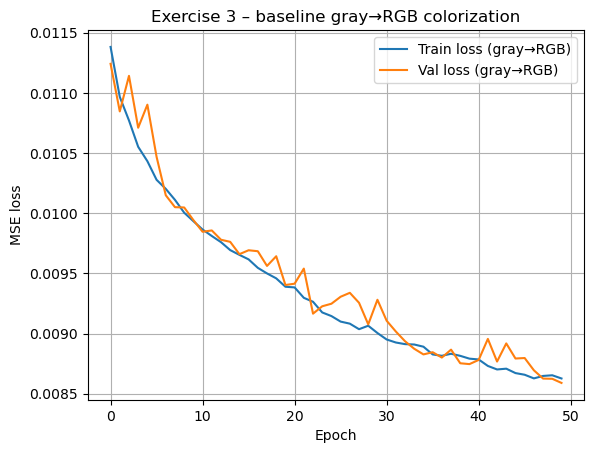

In [49]:
# --- Cell: plot baseline loss curves ---
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses_c, label="Train loss (gray→RGB)")
plt.plot(val_losses_c,   label="Val loss (gray→RGB)")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(True)
plt.title("Exercise 3 – baseline gray→RGB colorization")
plt.show()


In [50]:
# --- Cell: evaluation helper ---
def evaluate_mse(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            y_hat, _ = model(x)
            loss = criterion(y_hat, y)
            total += loss.item() * x.size(0)
    return total / len(loader.dataset)

test_mse_c = evaluate_mse(model_c, test_loader_c, criterion, device)
print(f"Baseline gray→RGB Test MSE: {test_mse_c:.6f}")


Baseline gray→RGB Test MSE: 0.008451


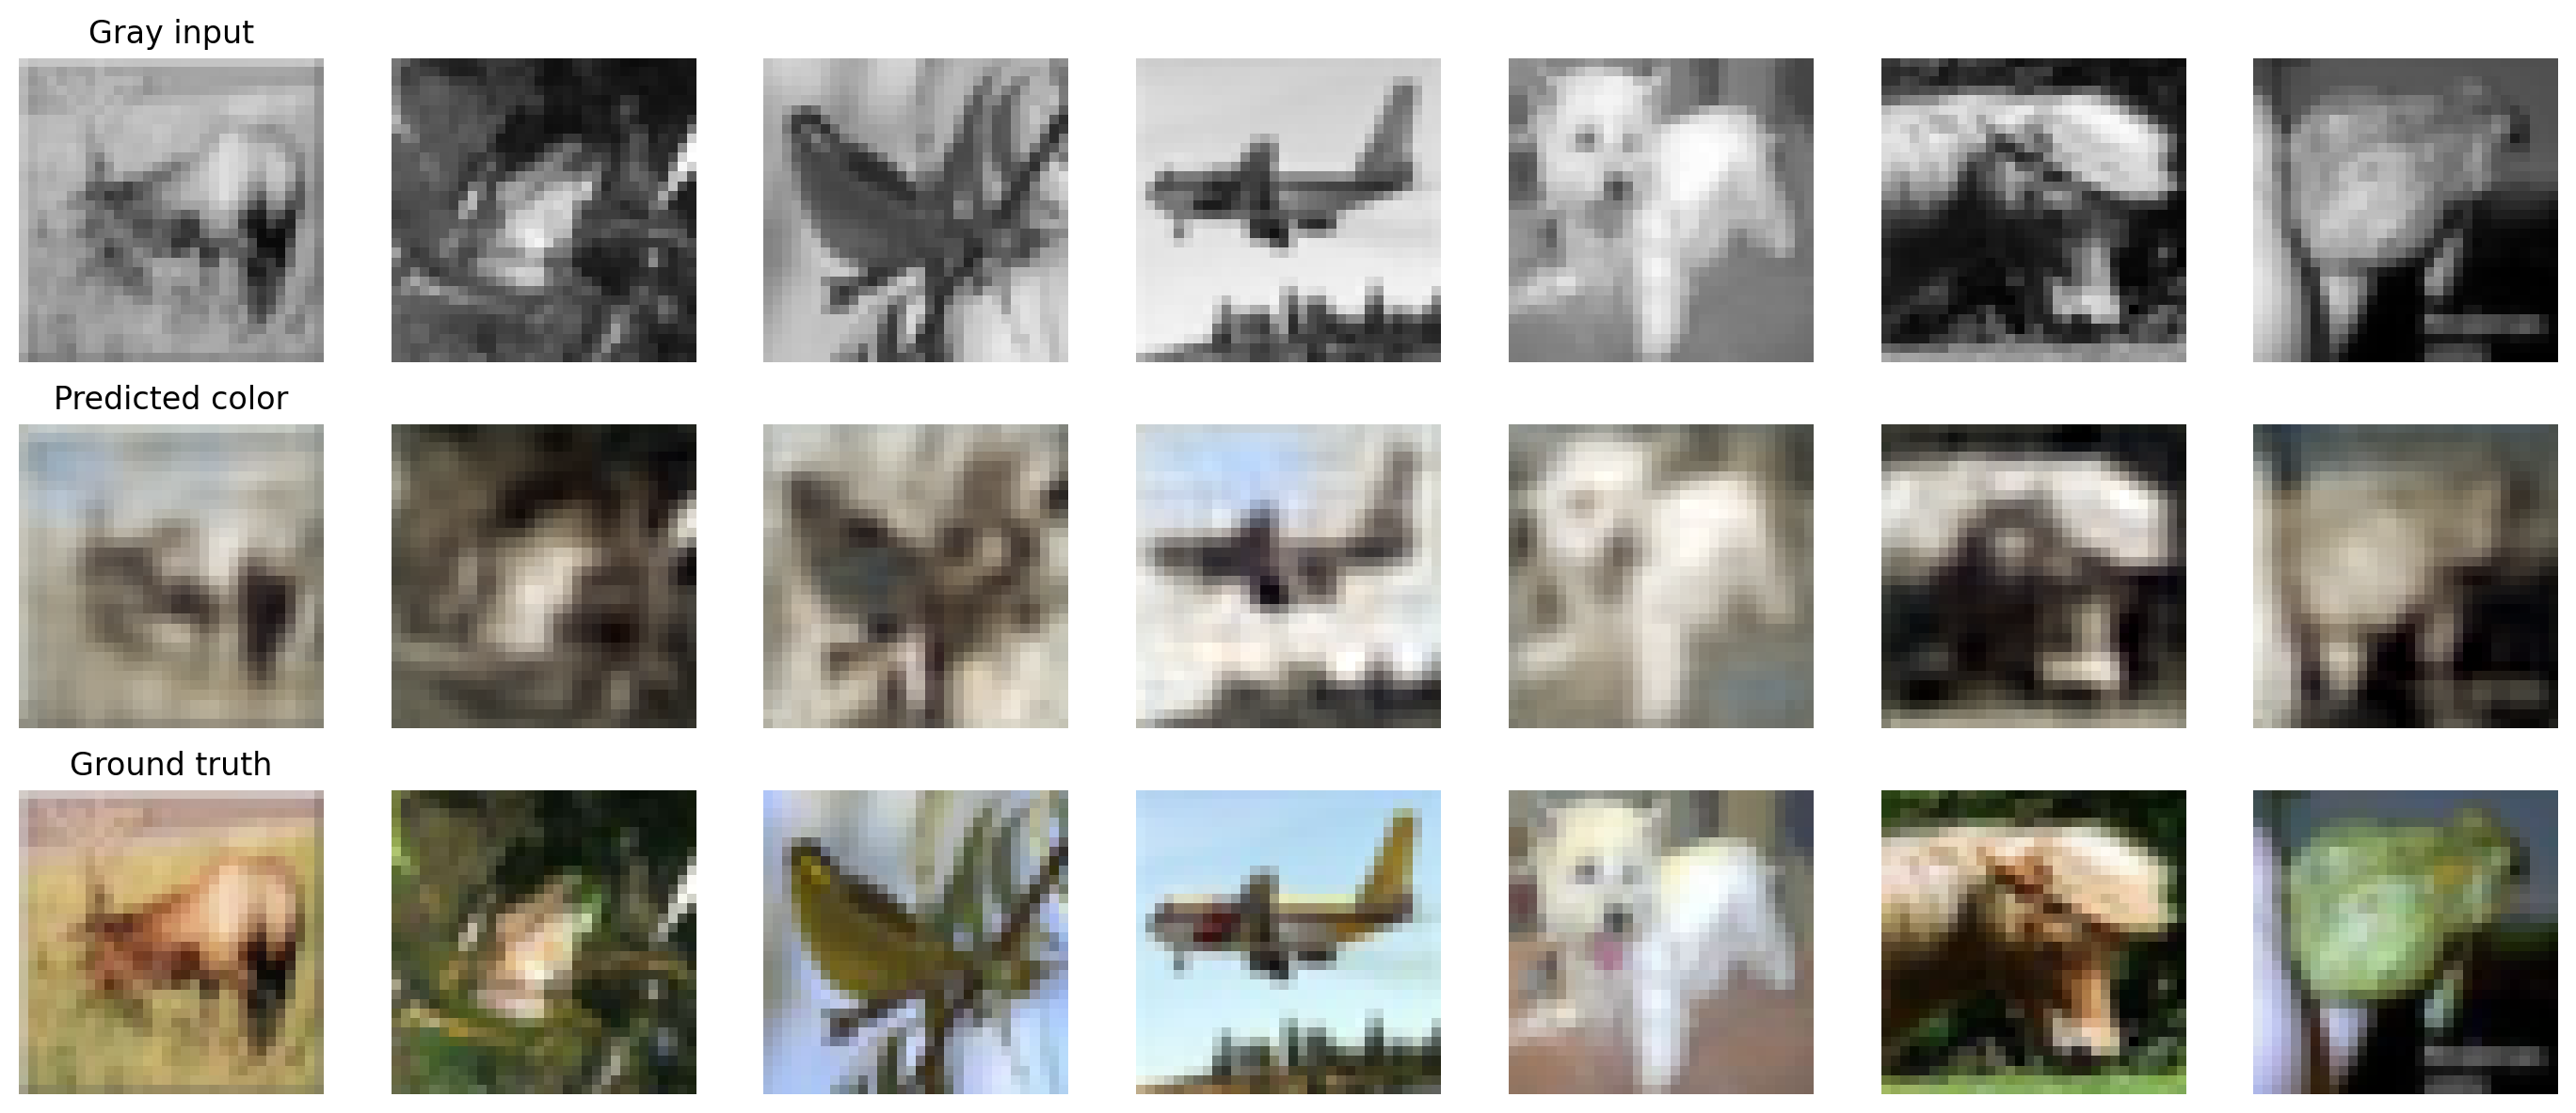

In [51]:
# --- Cell: visualise baseline colorization ---
model_c.eval()
xg, yg = next(iter(test_loader_c))  # grayscale batch, RGB batch
xg = xg.to(device)
yg = yg.to(device)

with torch.no_grad():
    yp, _ = model_c(xg)

gray = xg[:7].cpu().numpy().transpose(0,2,3,1)
pred = yp[:7].cpu().numpy().transpose(0,2,3,1).clip(0,1)
true = yg[:7].cpu().numpy().transpose(0,2,3,1)

fig, ax = plt.subplots(3, 7, figsize=(14, 6), dpi=200)
for i in range(7):
    ax[0, i].imshow(gray[i]); ax[0, i].axis('off')
    ax[1, i].imshow(pred[i]); ax[1, i].axis('off')
    ax[2, i].imshow(true[i]); ax[2, i].axis('off')

ax[0, 0].set_title("Gray input")
ax[1, 0].set_title("Predicted color")
ax[2, 0].set_title("Ground truth")
plt.tight_layout()
plt.show()


## 3.2 Chrominance-only colorization 

We now follow the hint from the lab sheet and work in the YCbCr colour space:

- Each RGB image is converted to YCbCr.
- **Input**: luminance channel Y (grayscale), shape [1, 32, 32]
- **Target**: chrominance channels [Cb, Cr], shape [2, 32, 32]
- The network predicts only (Cb, Cr). We then combine Y with predicted
  chrominance and convert back to RGB for visualization.


In [52]:
# --- Cell: dataset for chrominance-only colorization ---
from PIL import Image

class YCbCrChrominanceCIFAR(Dataset):
    """
    Returns:
      Y:   luminance channel, shape [1, 32, 32], in [0,1]
      CbCr: two chrominance channels, shape [2, 32, 32], in [0,1]
    """
    def __init__(self, baseds):
        self.baseds = baseds
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.baseds)

    def __getitem__(self, idx):
        img, _ = self.baseds[idx]      # PIL RGB
        ycbcr = img.convert("YCbCr")   # PIL YCbCr
        Y, Cb, Cr = ycbcr.split()

        Y_t   = self.to_tensor(Y)      # [1,H,W]
        Cb_t  = self.to_tensor(Cb)     # [1,H,W]
        Cr_t  = self.to_tensor(Cr)     # [1,H,W]
        CbCr_t = torch.cat([Cb_t, Cr_t], dim=0)  # [2,H,W]

        return Y_t, CbCr_t

# Build full dataset and split 80/10/10
all_yc = ConcatDataset([
    YCbCrChrominanceCIFAR(base_train),
    YCbCrChrominanceCIFAR(base_test)
])

n = len(all_yc)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = int(0.1 * n)

train_set_ch, val_set_ch, test_set_ch = random_split(all_yc, [n_train, n_val, n_test])

train_loader_ch = DataLoader(train_set_ch, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader_ch   = DataLoader(val_set_ch,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_ch  = DataLoader(test_set_ch,  batch_size=batch_size, shuffle=False, num_workers=0)

print("Chrominance-only dataset sizes:",
      len(train_set_ch), len(val_set_ch), len(test_set_ch))


Chrominance-only dataset sizes: 48000 6000 6000


In [ ]:
# --- Cell: Y->CbCr autoencoder ---
# Cb — Blue-difference Chrominance
# Cr — Red-difference Chrominance
# Y: grayscale luminance input
class ChrominanceAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: 1 -> 8 -> 12 -> 16
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           # 32 -> 16

            nn.Conv2d(8, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           # 16 -> 8

            nn.Conv2d(12, 16, kernel_size=3, padding=1),
            nn.ReLU(),                    # latent: [16, 8, 8]
        )

        # Decoder: 16 -> 12 -> 2 (Cb, Cr)
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),   # 8 -> 16
            nn.Conv2d(16, 12, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode="nearest"),   # 16 -> 32
            nn.Conv2d(12, 2, kernel_size=3, padding=1),
            nn.Sigmoid()   # Cb/Cr normalised to [0,1]
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

model_ch = ChrominanceAutoEncoder().to(device)
criterion_ch = nn.MSELoss()
optimizer_ch = optim.Adam(model_ch.parameters(), lr=1e-3)
epochs_ch = 50

print("Chrominance model on:", device)


Chrominance model on: cpu


In [54]:
# --- Cell: train chrominance-only colorizer ---
train_losses_ch = []
val_losses_ch = []

print()
print(f"{'Epoch':>5} | {'Train MSE':>10} | {'Val MSE':>10}")
print("-" * 32)

for e in range(1, epochs_ch + 1):
    # ---- TRAIN ----
    model_ch.train()
    running_train = 0.0

    for Y, CbCr in train_loader_ch:
        Y    = Y.to(device)      # [B,1,H,W]
        CbCr = CbCr.to(device)   # [B,2,H,W]

        optimizer_ch.zero_grad()
        pred_CbCr, _ = model_ch(Y)
        loss = criterion_ch(pred_CbCr, CbCr)
        loss.backward()
        optimizer_ch.step()

        running_train += loss.item() * Y.size(0)

    epoch_train = running_train / len(train_loader_ch.dataset)
    train_losses_ch.append(epoch_train)

    # ---- VALIDATION ----
    model_ch.eval()
    running_val = 0.0
    with torch.no_grad():
        for Y, CbCr in val_loader_ch:
            Y    = Y.to(device)
            CbCr = CbCr.to(device)
            pred_CbCr, _ = model_ch(Y)
            vloss = criterion_ch(pred_CbCr, CbCr)
            running_val += vloss.item() * Y.size(0)

    epoch_val = running_val / len(val_loader_ch.dataset)
    val_losses_ch.append(epoch_val)

    print(f"{e:5d} | {epoch_train:10.6f} | {epoch_val:10.6f}")



Epoch |  Train MSE |    Val MSE
--------------------------------
    1 |   0.003217 |   0.003073
    2 |   0.003061 |   0.003013
    3 |   0.003012 |   0.003019
    4 |   0.003004 |   0.002924
    5 |   0.002969 |   0.002917
    6 |   0.002961 |   0.002903
    7 |   0.002948 |   0.002890
    8 |   0.002944 |   0.002905
    9 |   0.002930 |   0.002884
   10 |   0.002927 |   0.002873
   11 |   0.002921 |   0.002880
   12 |   0.002915 |   0.002878
   13 |   0.002913 |   0.002873
   14 |   0.002917 |   0.002855
   15 |   0.002915 |   0.002854
   16 |   0.002898 |   0.002867
   17 |   0.002900 |   0.002868
   18 |   0.002894 |   0.002848
   19 |   0.002905 |   0.002842
   20 |   0.002891 |   0.002864
   21 |   0.002890 |   0.002900
   22 |   0.002898 |   0.002835
   23 |   0.002881 |   0.002858
   24 |   0.002884 |   0.002930
   25 |   0.002883 |   0.002845
   26 |   0.002876 |   0.002828
   27 |   0.002872 |   0.002849
   28 |   0.002875 |   0.002827
   29 |   0.002880 |   0.002837
   30 

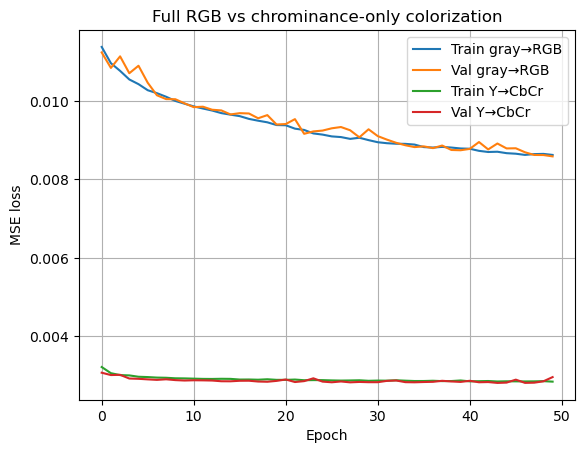

In [55]:
# --- Cell: overlay loss curves ---
plt.figure()
plt.plot(train_losses_c,  label="Train gray→RGB")
plt.plot(val_losses_c,    label="Val gray→RGB")
plt.plot(train_losses_ch, label="Train Y→CbCr")
plt.plot(val_losses_ch,   label="Val Y→CbCr")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(True)
plt.title("Full RGB vs chrominance-only colorization")
plt.show()


In [56]:
# --- Cell: test MSE for chrominance model ---
def evaluate_mse_chroma(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for Y, CbCr in loader:
            Y    = Y.to(device)
            CbCr = CbCr.to(device)
            pred_CbCr, _ = model(Y)
            loss = criterion(pred_CbCr, CbCr)
            total += loss.item() * Y.size(0)
    return total / len(loader.dataset)

test_mse_ch = evaluate_mse_chroma(model_ch, test_loader_ch, criterion_ch, device)
print(f"Baseline gray→RGB Test MSE:        {test_mse_c:.6f}")
print(f"Chrominance-only (Y→CbCr) Test MSE: {test_mse_ch:.6f}")


Baseline gray→RGB Test MSE:        0.008451
Chrominance-only (Y→CbCr) Test MSE: 0.002951


In [57]:
# --- Cell: helper to convert Y + CbCr tensors back to RGB tensors ---
from torchvision.transforms.functional import to_pil_image

def ycbcr_tensors_to_rgb_batch(Y, CbCr):
    """
    Y:   [B,1,H,W] in [0,1]
    CbCr:[B,2,H,W] in [0,1]
    returns: [B,3,H,W] RGB tensors in [0,1]
    """
    to_tensor = transforms.ToTensor()
    imgs = []
    B = Y.size(0)
    for i in range(B):
        y_pil  = to_pil_image(Y[i])          # 'L'
        cb_pil = to_pil_image(CbCr[i,0:1])   # 'L'
        cr_pil = to_pil_image(CbCr[i,1:2])   # 'L'

        ycbcr_pil = Image.merge("YCbCr", (y_pil, cb_pil, cr_pil))
        rgb_pil   = ycbcr_pil.convert("RGB")
        rgb_t     = to_tensor(rgb_pil)       # [3,H,W] in [0,1]
        imgs.append(rgb_t)

    return torch.stack(imgs, dim=0)


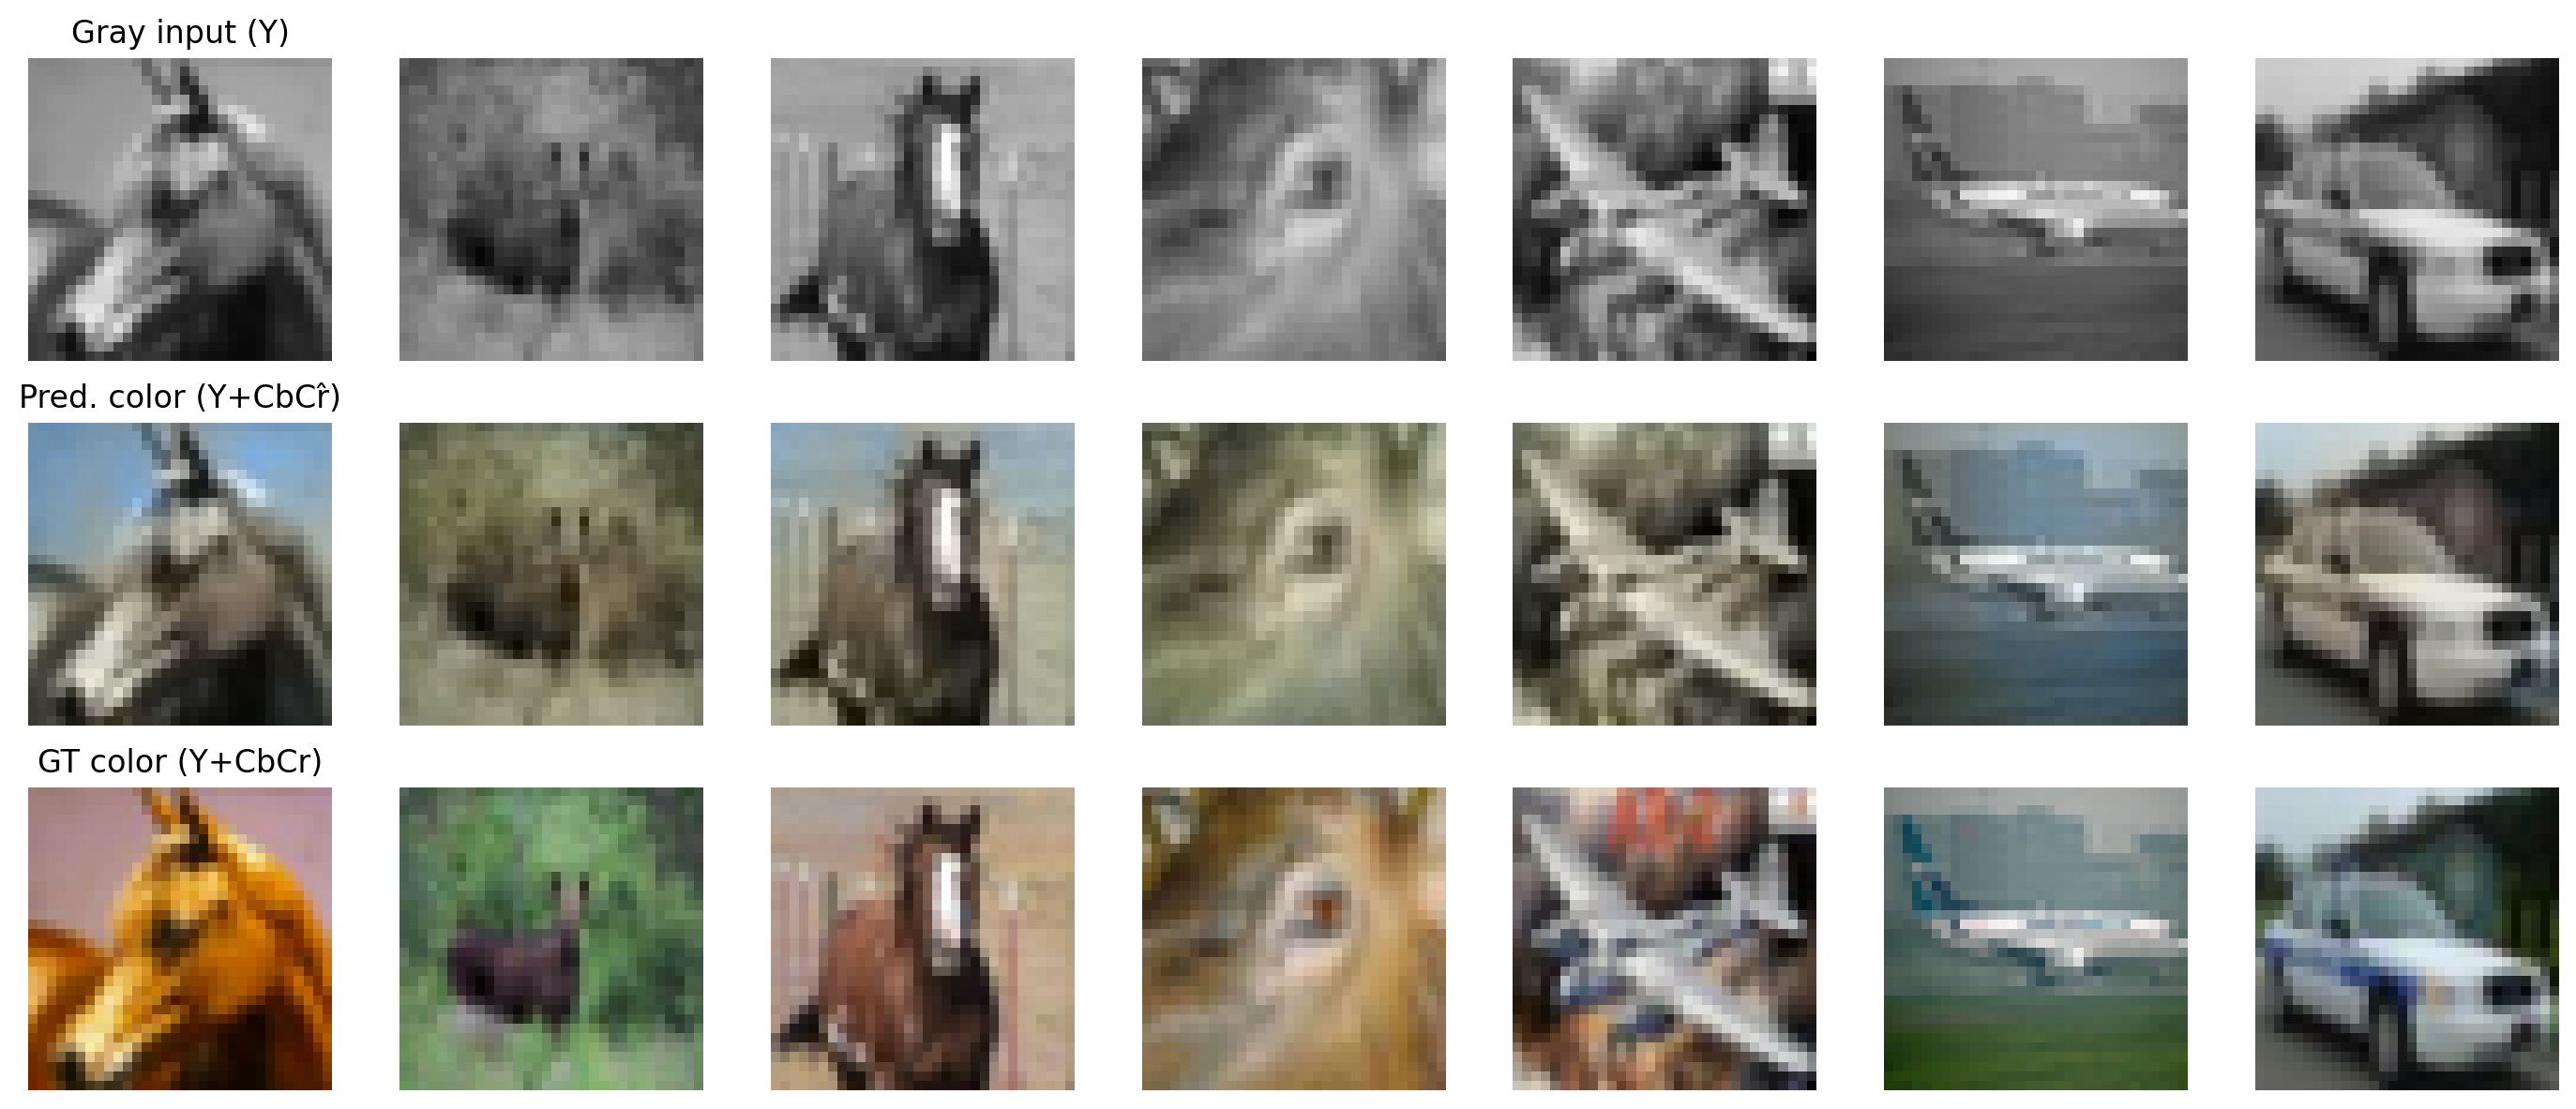

In [58]:
# --- Cell: visualise chrominance-only colorization ---
model_ch.eval()
Y_batch, CbCr_batch = next(iter(test_loader_ch))
Y_batch    = Y_batch.to(device)
CbCr_batch = CbCr_batch.to(device)

with torch.no_grad():
    pred_CbCr_batch, _ = model_ch(Y_batch)

Y_cpu        = Y_batch.cpu()
CbCr_true    = CbCr_batch.cpu()
CbCr_pred    = pred_CbCr_batch.cpu().clamp(0, 1)

rgb_true = ycbcr_tensors_to_rgb_batch(Y_cpu, CbCr_true)
rgb_pred = ycbcr_tensors_to_rgb_batch(Y_cpu, CbCr_pred)

gray_rgb = Y_cpu.repeat(1, 3, 1, 1)

k = 7
fig, ax = plt.subplots(3, k, figsize=(14, 6), dpi=200)
for i in range(k):
    ax[0, i].imshow(gray_rgb[i].numpy().transpose(1, 2, 0))
    ax[0, i].axis('off')
    ax[1, i].imshow(rgb_pred[i].numpy().transpose(1, 2, 0))
    ax[1, i].axis('off')
    ax[2, i].imshow(rgb_true[i].numpy().transpose(1, 2, 0))
    ax[2, i].axis('off')

ax[0, 0].set_title("Gray input (Y)")
ax[1, 0].set_title("Pred. color (Y+CbCr̂)")
ax[2, 0].set_title("GT color (Y+CbCr)")
plt.tight_layout()
plt.show()


# Results
- Baseline gray→RGB Test MSE:        0.008451
- Chrominance-only (Y→CbCr) Test MSE: 0.0029511

### Shortcomings:
The baseline model does a poor job at not only predicting the colors, but also reproducing the images. This can be seen with the test MSE of 0.008451. This could be because we are not looking at the chrominance of the model at all.

The Chrominance-only model does a great job of reproducing the image, and does better at coloring the images, but the colors area always slightly off.

It could be that the model is too small to be able to accurately reproduce these images with the correct colors. It could also be that MSE loss is not the best way to calculate the loss as it is not perceptually meaningful. Finally, for a harder task such as this one, it could be that there aren't enough images for the model to train on.

### Potential Improvements:
Some improvements include:
- using a different loss function that might be more perceptually meaningful
- using a larger architecture that is able to learn more image features
- using a different optimizer such as AdamW or SGD

